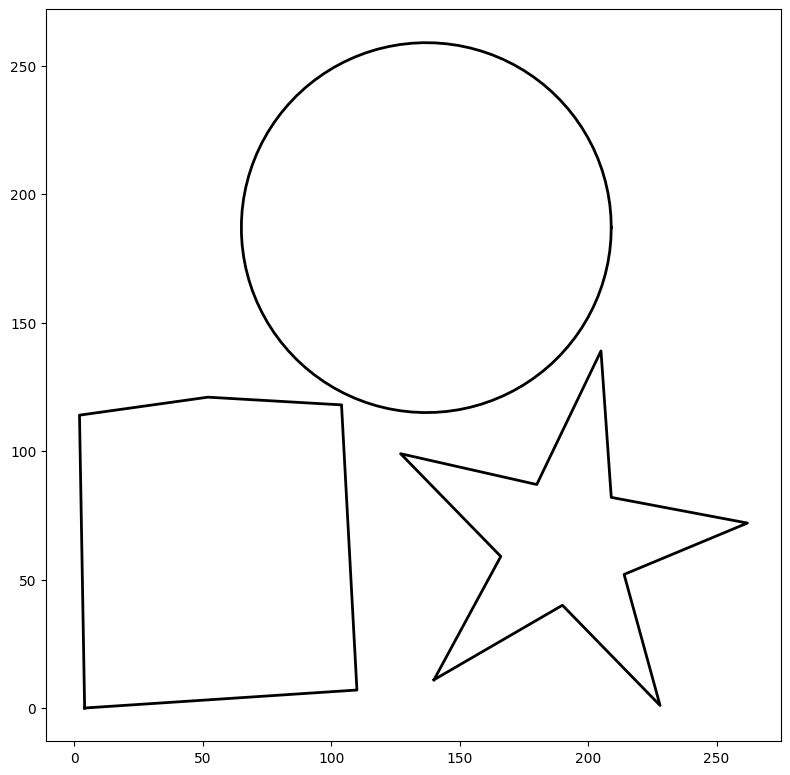

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to read the CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Function to detect shapes
def detect_shape(contour):
    shape = "unidentified"
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)

    if len(approx) == 3:
        shape = "triangle"
    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        shape = "square" if 0.95 <= aspect_ratio <= 1.05 else "rectangle"
    elif len(approx) > 4:
        area = cv2.contourArea(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circle_area = np.pi * (radius ** 2)
        shape = "circle" if abs(1 - (area / circle_area)) <= 0.2 else "polygon"
    
    return shape

# Function to regularize and preserve shapes
def regularize_curves(paths_XYs):
    regularized_paths = []
    for XYs in paths_XYs:
        regularized_subpaths = []
        for XY in XYs:
            if len(XY) > 2:
                # Convert to contour format for OpenCV
                contour = XY.reshape((-1, 1, 2)).astype(np.int32)
                shape = detect_shape(contour)

                if shape == "circle":
                    (x, y), radius = cv2.minEnclosingCircle(contour)
                    center = (int(x), int(y))
                    radius = int(radius)
                    approx_curve = np.array([[center[0] + radius * np.cos(theta), 
                                              center[1] + radius * np.sin(theta)] 
                                             for theta in np.linspace(0, 2 * np.pi, 100)])
                else:
                    epsilon = 0.003 * cv2.arcLength(contour, True)
                    approx_curve = cv2.approxPolyDP(contour, epsilon, True)
                    
                regularized_subpaths.append(approx_curve.squeeze())
            else:
                regularized_subpaths.append(XY)
        regularized_paths.append(regularized_subpaths)
    return regularized_paths

# Function to complete curves (if needed)
def complete_curves(paths_XYs):
    completed_paths = []
    for XYs in paths_XYs:
        completed_subpaths = []
        for XY in XYs:
            if len(XY) > 2 and not np.allclose(XY[0], XY[-1]):  # If not closed
                XY = np.vstack([XY, XY[0]])  # Close the curve
            completed_subpaths.append(XY)
        completed_paths.append(completed_subpaths)
    return completed_paths

# Function to plot the curves
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c='black', linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Main function to process and display the curves
def process_and_display_curves(input_csv):
    paths_XYs = read_csv(input_csv)
    regularized_paths = regularize_curves(paths_XYs)
    completed_paths = complete_curves(regularized_paths)
    plot(completed_paths)

# Input CSV file path
input_csv_path = "/Users/shakeelahmad/Adobe/isolated.csv"

# Process and display the curves
process_and_display_curves(input_csv_path)

#Option2